## Intermediate Python - week 6 - Machine Learning Project Part 2


### Recap
* Last time we looked at how to prepare real-world data so that it's suitable for machine learning, and we had a first look at fitting some models to the data

This week:
* I will introduce some more powerful machine learning models
* We will look at the specific algorithms in more details and understand a little bit of what's going on under the hood
* We will look at cross validation as a means to get more out of your training data

*

In [1]:
# recap from last time: import the training data, perform a stratified split based on housing income catergory, run the numerical and catagorical data through separate pipelines

import sklearn
from sklearn.model_selection import StratifiedShuffleSplit

# Common imports
import numpy as np
import os
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
np.random.seed(42)

housing = pd.read_csv("https://raw.githubusercontent.com/AstraZeneca-Code-Club/intermediate_python/main/datasets/housing/housing.csv")

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
        ])


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

housing_num = housing.drop("ocean_proximity", axis=1)
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

 Linear Regression models are about as straight forward as you can get - they fit a linear function that, given the input data, tries to predict the output. Whilst it's fitting, it calculates a loss metric - how far the predictions are from the actual value - and makes an adjustment to its coefficients using a gradient descent algorithm


How a linear model works:
* The algorithm tries to fit a function that looks something like
$$ f(x) = a_{1}x_{1} + a_{2}x_{2} + ... + a_{n}x_{n}$$

This makes the strong assumption that there is a linear relationship between the attributes of your data and the target you're predicting, so it may fail to make good predictions in many cases

### A quick dive into how the algorithm 'learns' to predict from its data

One of the central concepts of machine learning is the concept of a 'loss function' and an associated algorithm called 'gradient descent'.
This is the strategy by which a model can be fitted to a dataset.

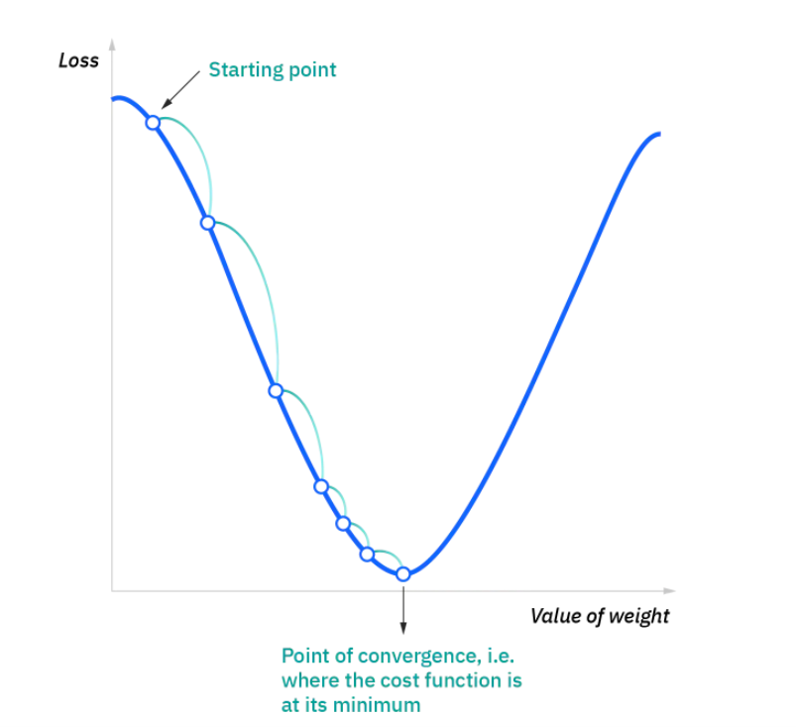

We first need a loss function that computes how far away the model's current predictions are from the actual values.
This is our current position on the loss surface.  Crucially, the loss function needs to be continuous and differentiable with respect to the parameters.
From here, we use the computed derivatives to make small changes to the function's parameters, in the direction of steepest descent of the loss function.
If all goes well, the model will find itself in the loss function's global minimum, and training is done!

There are several implementations of this idea of 'gradient descent' that are useful in specific applications, but they all follow the same general concept

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
# like with the preprocessing functions, SKlearn models provide a fit and a transform method (for training and predicting respectively)
lin_reg.fit(housing_prepared, housing_labels)

In [ ]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Compare against the actual values:

In [ ]:
print("Labels:", list(some_labels))

In [ ]:
some_data_prepared

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse



In [ ]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

## More advanced models - Decision Trees

Decision trees algorithms, in their various flavours  and implementations, are extensively used in machine learning.


In their most straightforward form, a decision tree simply asks a series of questions of the data and follows the tree down until it makes its prediction.



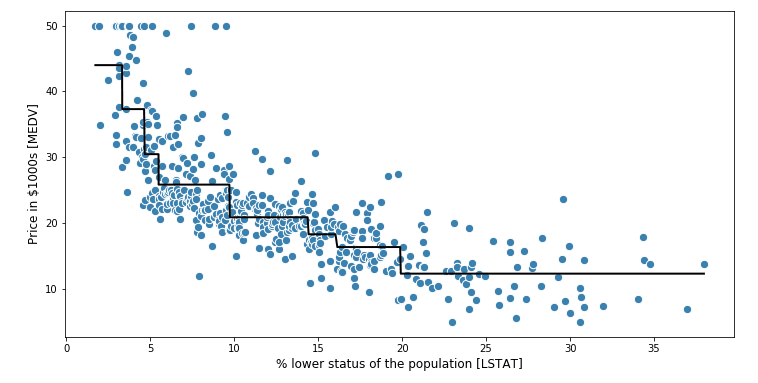
During training the model learns how to partition the data, based on the loss function, to improve its predictions

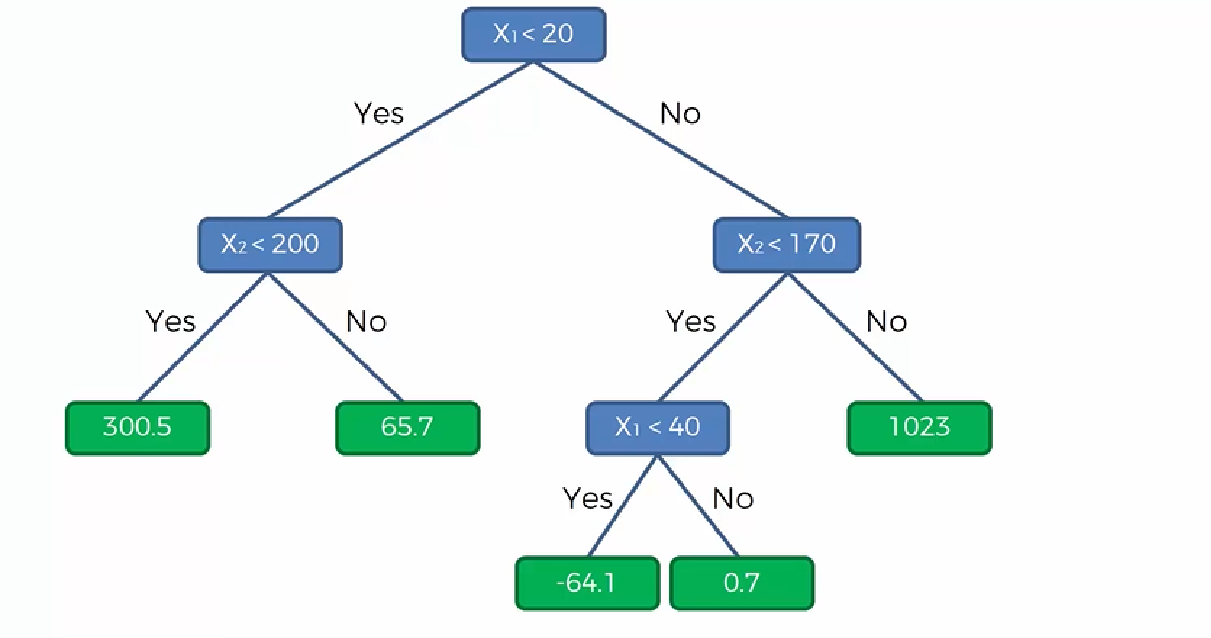

## Exercise set 1

For the following exercises, you should use the code provided above for the linear regression model as a starting point.  You can look up the implementation details for the decision tree regressor if you want to check out different ways to 

In [ ]:
from sklearn.tree import DecisionTreeRegressor
# 1) Instantiate a decision tree regressor and fit it to the training data, as we did above for the LinReg model


In [ ]:
# 2) use your trained decision tree to make predicitons on the dataset

# 3) calculate the mean squared error for the decision tree model and compare it to the linear regression model

Incredibly, we appear to have built a perfect machine learning algorithm - you should see zero loss for the decision tree!
Is it too good to be true? Well...yes.  Almost always.

### Overfitting
What we have seen here is the idea of overfitting.  This is where the model fits extremely well to the training data,
but it doesn't generalise to cases outside of the test set.  This tends to happen when the data is too small (or too noisy) relative to the complexity of the model, so it starts the noise in the data rather than any general trend.
 
 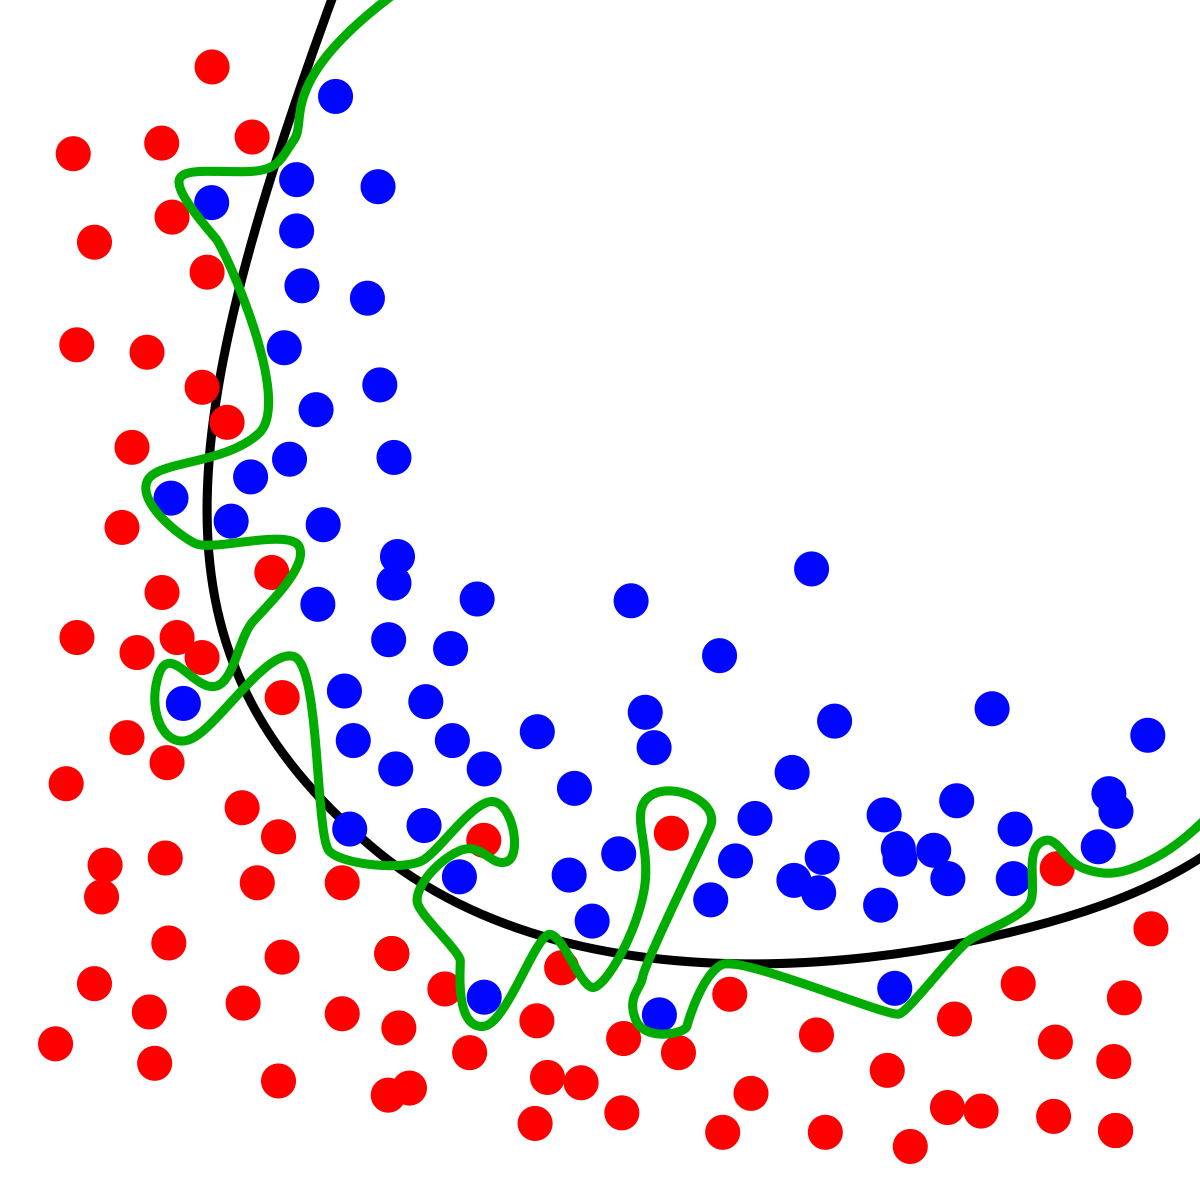

One quick way to get a better idea of how your model is performing is to use cross validation.  Instead of training on a single block of data and testing on the held out set, CV takes the training set and splits it into k folds.  It then trains the model k times, using each fold once as the test set and the other k-1 as training data.
This is a great way to avoid the model overfitting, and you can get an idea of the confidence in a certain performance metric, through the standard deviation calculated accross the k folds

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
# let's define a quick utility function to make comparing our model performance easiser
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)



## Random Forest Models
Random forests are extremely powerful machine learning models, and they tend to be one of my 'goto' first model to try out when
I'm first looking at a dataset.

There several different implementation of the same idea, so if you want to learn more, look up the XGBoost package
For today we'll stick the the SKlearn implementation

The basic idea with a random forest is to take many different decision tree predictors, and rely on the principle of
'wisdom of crowds' idea that random errors in each classifier will tend to cancel each other out, and the aggregated
predictions of the ensemble of models outperforms any single model.

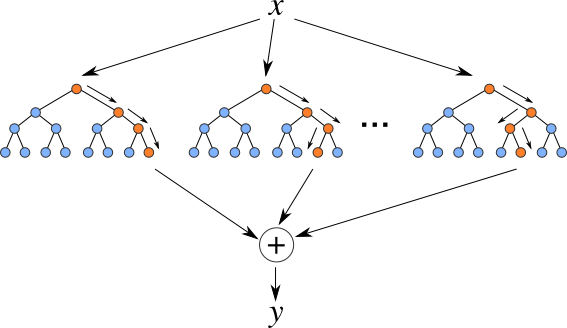


## Exercise Set 2: Random Forest Regressors

In [ ]:

# 1) Train a random forest regressor (look up the sklearn docs if you want to change parameters from the defaults)

# 2) calcualate performance metrics the the random forest

# 3) use the cross validation approach to evaluate the random forest model perfmance on 10 folds of the training data

In [ ]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()


## Tuning your model

Once you've got a few models you think will perform well for your application, you need to find the settings - hyperparameters -
that give optimal performance without overfitting.

SKlearn has a helpful GridSearch implementation to perform this optimisation for us.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10], 'max_features': [2, 4]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 4]},
]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
grid_search = GridSearchCV(forest_reg, param_grid, cv=2,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)



In [ ]:
# return the optimal hyperparameters
grid_search.best_params_

In [ ]:
# return the trained model
grid_search.best_estimator_

Let's look at the score of each hyperparameter combination tested during the grid search:

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

## Exercise set 3 / Homework

In [4]:
# 1) Choose some values for the parameters of the grid search from above and see if you can beat the previous best score the the RF model (don't go mad, stick to 3 params per catagory)

# 2) Try using a support vector machine (see the sklearn docs), and compare performance to the models you've trained already